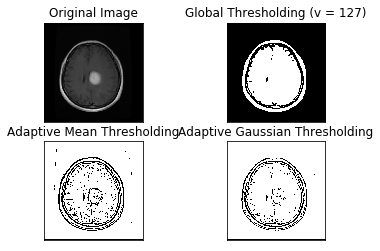

In [2]:
import cv2
import numpy as np
from skimage import io
from skimage import measure
import matplotlib.pyplot as plt
  
#read image
image = cv2.imread('H:/FYP/interim/10.jpg',0)

#preprocess using median blur
img = cv2.medianBlur(image,5)

ret,th1 = cv2.threshold(img,40,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

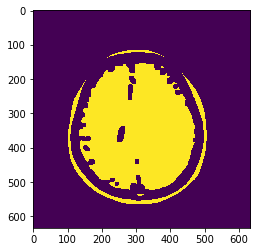

In [3]:
#erosion using morphological operations

kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(th1, kernel, iterations = 4)
plt.imshow(erosion)

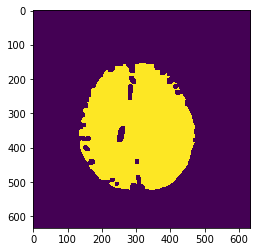

In [4]:
# perform a connected component analysis on the eroded image, then initialize a mask to store only the "large" components

labels = measure.label(erosion, neighbors=8, background=0)
mask1 = np.zeros(erosion.shape, dtype="uint8")
 
# loop over the unique components
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue
 
	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(erosion.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
 
	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels > 15000:
		mask1 = cv2.add(mask1, labelMask)
        
plt.imshow(mask1)

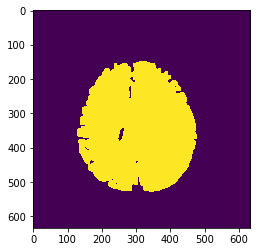

In [5]:
mask = cv2.dilate(mask1,kernel,iterations = 4)
plt.imshow(mask)

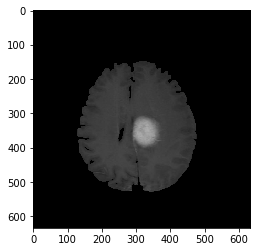

In [6]:
#extract the brain using the mask
img = io.imread("H:/FYP/interim/10.jpg")
mask2 = np.where((mask<200),0,1).astype('uint8')

brain_img = img*mask2[:,:,np.newaxis]

plt.imshow(brain_img)

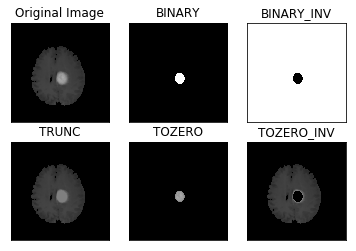

In [7]:
#threshold segmentation

img = cv2.medianBlur(brain_img, 9)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

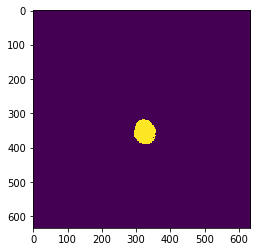

In [8]:
#watershed transformation

gray = cv2.cvtColor(brain_img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,125,255,cv2.THRESH_BINARY)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
et, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(markers)
plt.imshow(img)

plt.imshow(thresh)

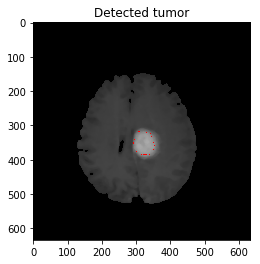

In [9]:
plt.title('Detected tumor')
plt.imshow(img)

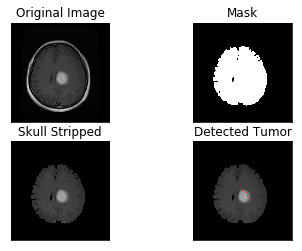

In [13]:
title = ['Original Image','Mask','Skull Stripped','Detected Tumor']
result = [image, mask, brain_img, img]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(result[i],'gray')
    plt.title(title[i])
    plt.xticks([]),plt.yticks([])

plt.show()